# **TP Wavelets**

In this TP, we will work on some fundamental concepts in Wavelets and compression of images.

First we'll briefly check the limitations of the Fourier transform. We'll then check some fundamental properties of a family of Wavelets and compute the Wavelet transform of a very simple signal. In the second part of the TP, we will use the DWT to compress and image.

Make sure to sequentially run all the cells in each section, so that the intermediate variables / packages will carry over to the next cell

We recommend you save a copy of this colab in your drive so you don't lose progress!

**Note 1:** As mentioned in the course and since there's not any policy regarding ChatGPT at Télécom level yet, you can use it. However, using ChatGPT without understanding their outputs is not OK, and will be penalized accordingly in your grade. Please be sure of all the functions you'll use.

**Note 2:** Several points have associated questions. When answering these questions, all responses should be properly justified. ChatGPT answers are very easy to spot.

**Note 3:** Always plot the functions and outputs you're generating. If the output or function is not properly plotted/shown, this will reduce points in your grade.

# Setup
First, we install PyWavelets

In [22]:
!pip install PyWavelets


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import pywt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy

pywt.__version__

'1.4.1'

# Important
Google Colab is an interesting tool to try things out quickly. However, Google Colab and more general Notebooks are not meant to be an Integrated Development Environment (IDE). For a real job, please use an actual IDE like PyCharm or VS Code.

# Limitation of the Fourier Transform
*   Create a sinusoidal signal of 2.5 seconds of duration.
*   Set up a sampling rate of 20kHz. The signal should be divided in 5 parts of 0.5 seconds of duration each.
*  The signal should have the following frequencies in this order {10 Hz, 30 Hz, 60 Hz, 30 Hz, 10 Hz}.

In [24]:
sinf10 = [np.sin(2*np.pi*10*x) for x in np.linspace(0,0.5,10000)]
sinf30 = [np.sin(2*np.pi*30*x) for x in np.linspace(0.5,1,10000)]
sinf60 = [np.sin(2*np.pi*60*x) for x in np.linspace(1,1.5,10000)]
sin2f30 = [np.sin(2*np.pi*30*x) for x in np.linspace(1.5,2,10000)]
sin2f10 = [np.sin(2*np.pi*10*x) for x in np.linspace(2,2.5,10000)]

signal = sinf10+sinf30+sinf60+sin2f30+sin2f10
time = np.linspace(0,2.5,50000)


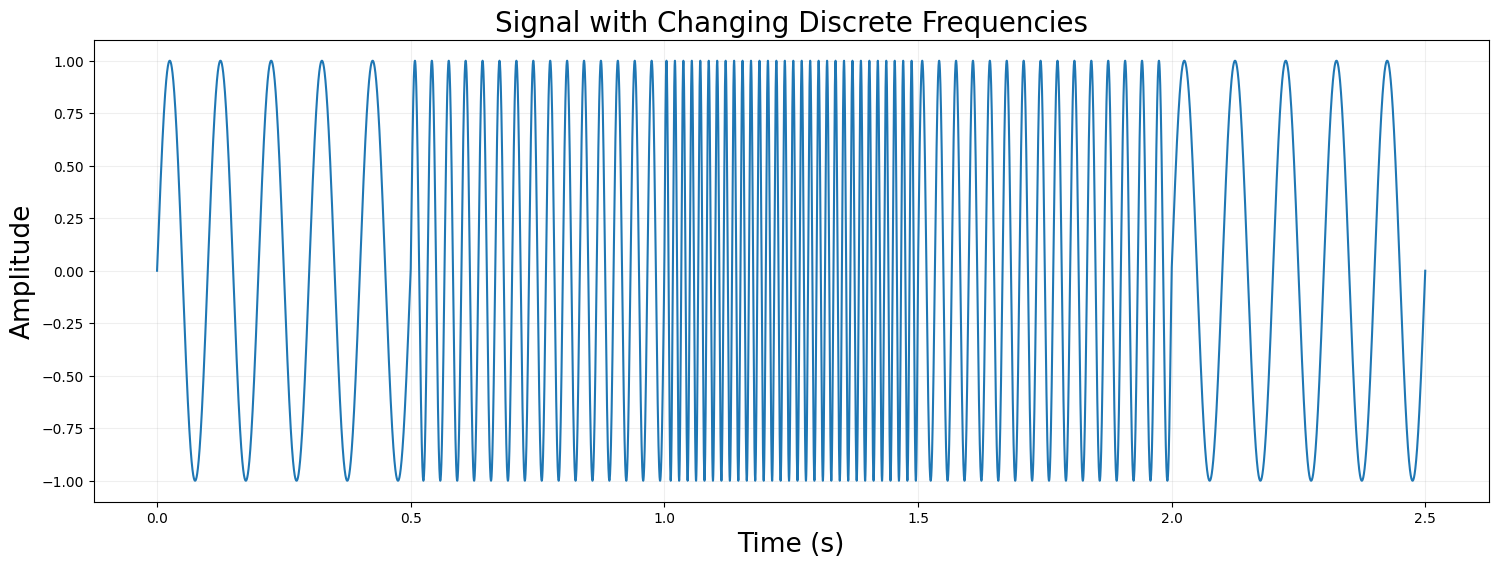

In [25]:
font_size = 20

plt.figure(figsize=(18, 6))

plt.plot(time, signal, linewidth=1.5)
plt.title('Signal with Changing Discrete Frequencies', fontsize=font_size)
plt.xlabel('Time (s)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.grid(alpha=0.2)

Now, you should compute the Discrete Fourier Transform of the signal. You can use any library from Python you prefer. You might need to cut the x-axis in the Fourier transform up to 100 Hz in the visualization. Please check https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html

c:\Users\maelm\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 100.0)

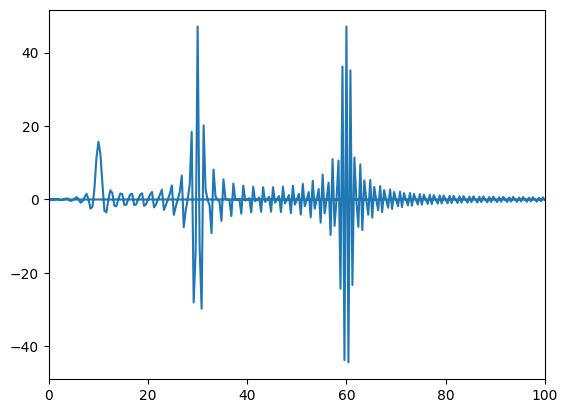

In [26]:
fourier_transform = np.fft.fft(signal)
frequencies = np.fft.fftfreq(50000,1/20000)
plt.plot(frequencies,fourier_transform)
plt.xlim(0,100)

**QUESTIONS**

1) Does the established sampling rate satisfy the Nyquist-Shannon sampling theorem to avoid aliasing? Please justify.

2) What can you say from the signal looking **only** at the Fourier transform?

3) Can you be certain about the location of some frequency component in the time domain? Why?

**YOUR ANSWERS HERE:**

1) Nyquist-Shannon conditon : $f_{sampling} > 2*f_{max}$, here $f_{sampling}=20kHz$ and $f_{max} \approx 60Hz$ so the sampling rate verifies the condition, there is no aliasing.

2) The signal is not sinusoidal, otherwise there would only be one spike in its Fourier transform but it looks like the signal contains components which have frequencies 10Hz, 30Hz and 60Hz

3) The signal we have defined above is a sum of sine waves multiplied by door functions. Its fourier transform is thus going to look like three spikes convoluted with cardinal sines. We can then retrieve our three original frequencies by looking at the center of each cardinal sine in the graph of the fourier transform: 10, 30 and 60 Hz.

# **Mother Wavelet**
As we saw in the course, a wavelet is not just a function but a whole family of functions that satisfy certain requirements. In this part of the TP we're gonna work with the Morlet wavelet defined as follows: $\Psi(t)=k e^{iw_0t}e^{-\frac{1}{2}(\frac{t}{\sigma})^2}$. Please generate a Morlet wavelet in Python **WITHOUT using PyWavelets** with the following parameters:

-Center frequency of the wavelet = 10 Hz

-Sampling rate $\eta$ = 20000 Hz

-$k=\frac{1}{\sqrt{\eta}}$

-$\sigma = 0.1$

You can generate the wavelet between -1 and 1 seconds, so the time duration of the wavelet is 2 seconds. For this part, you just need to generate the real part of the wavelet.

Text(0, 0.5, 'Amplitude')

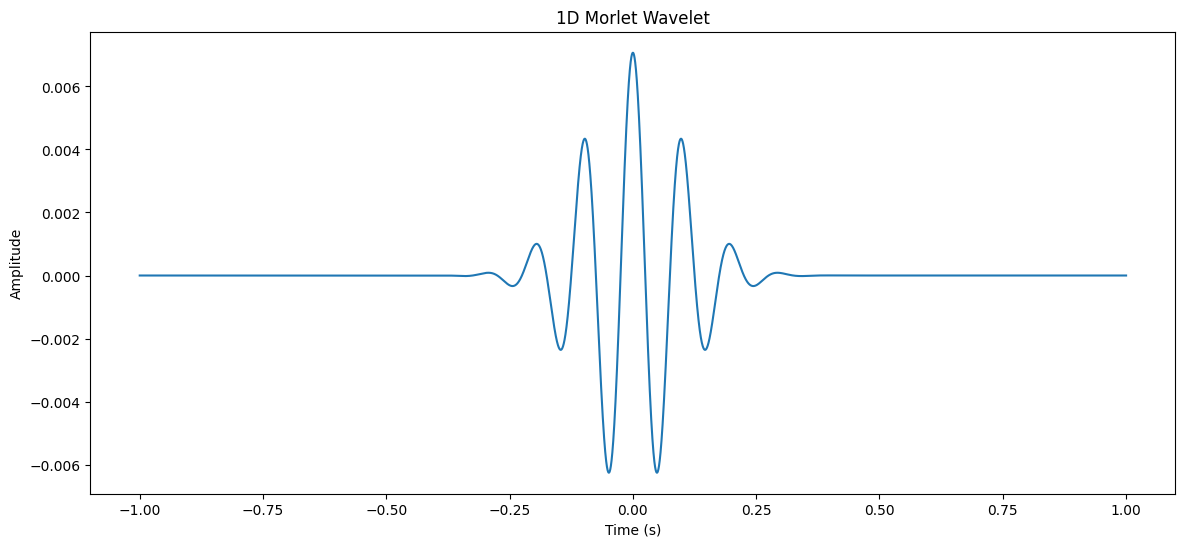

In [27]:
# Your code here
w0 = 2*np.pi*10
fs = 20000
k = 1/np.sqrt(fs)
sigma = 0.1
time = np.linspace(-1,1,40000)
morlet = [k*np.exp(1j*w0*x-1/2*(x/sigma)**2)for x in time]

# Plot the real part of the Morlet wavelet in 1D
plt.figure(figsize=(14, 6))

plt.plot(time,np.real(morlet))
plt.title('1D Morlet Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Please show that the mother wavelet we just created satisfies the admissibility and the finite energy conditions:

In [28]:
# Your code here
print(np.trapz(np.real(morlet),time))
energie = [np.abs(x)**2 for x in morlet]
print(np.trapz(energie,time))

4.741824523390158e-12
8.862269254527582e-06


**Note:** In real life, you have to deal with finite-precision related problems. Therefore, if for the admissibility condition you don't have exactly the value you were expecting for, don't worry.

# **Convolution**

As we saw in the course, we need a measure of similarity to compute the wavelet transform. We also saw that we can easily compute the shift in time and similarity calculation with the 1-D convolutions.

* Generate a chirp sinusoidal signal from -5 to 5 seconds with an initial frequency of 5 Hz and final frequency of 15 Hz and sampling rate of 20kHz:

Text(0.5, 0, 'Time')

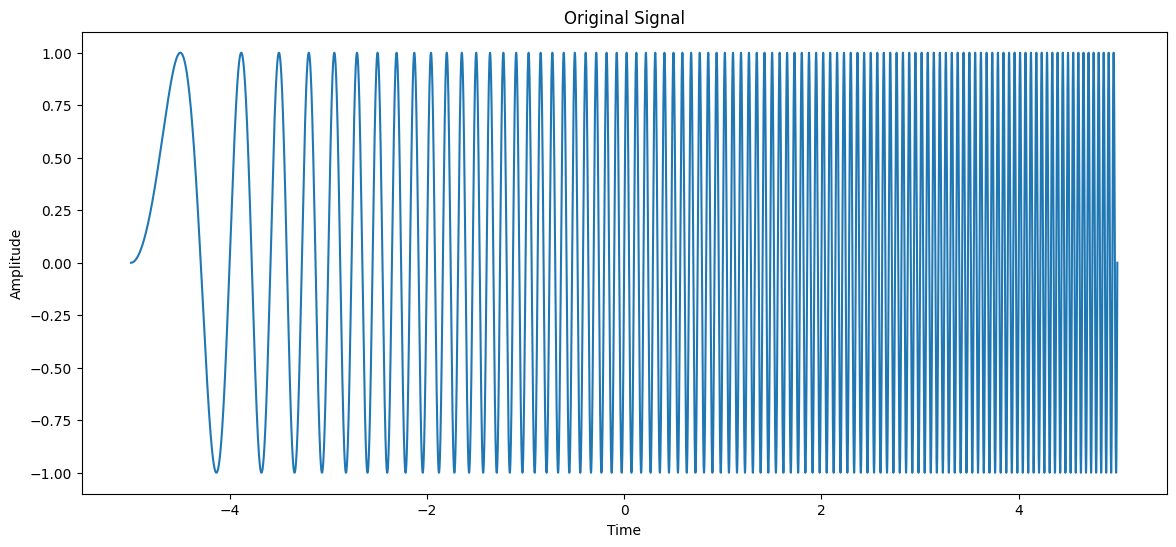

In [29]:
time_signal = np.linspace(-5,5,200000)

chirp = [np.sin(2*np.pi*(x+10)*x) for x in time_signal]
plt.figure(figsize=(14, 6))
plt.plot(time_signal, chirp)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Now create a Morlet wavelet with the following parameters:

* Center frequency of the wavelet = 10 Hz

* Sampling rate $\eta$ = 20000 Hz

* $k=\frac{1}{\sqrt{\eta}}$
* $\sigma = 0.2$

Duration: 2 seconds

Text(0.5, 0, 'Time')

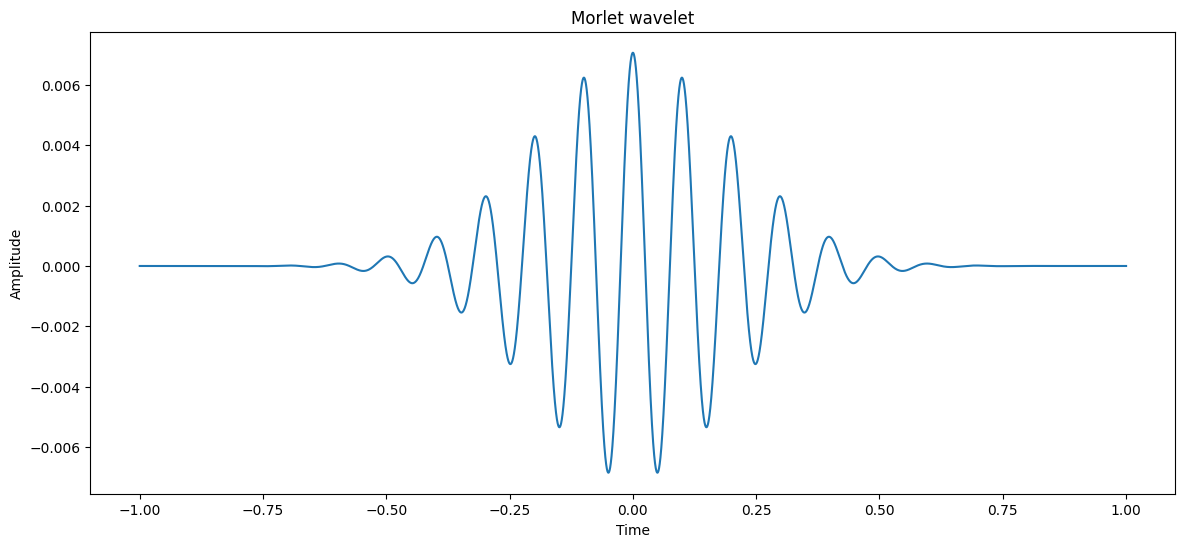

In [30]:
w0 = 2*np.pi*10
fs = 20000
k = 1/np.sqrt(fs)
sigma = 0.2
time = np.linspace(-1,1,40000)
morlet = [k*np.exp(1j*w0*x-1/2*(x/sigma)**2)for x in time]

plt.figure(figsize=(14, 6))
plt.plot(time, np.real(morlet))
plt.title('Morlet wavelet')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Compute the convolution between the signal and $Re(\Psi(t))$. For reference on how to perform convolution with scipy 'convolve' function, please check https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

Text(0, 0.5, 'Amplitude')

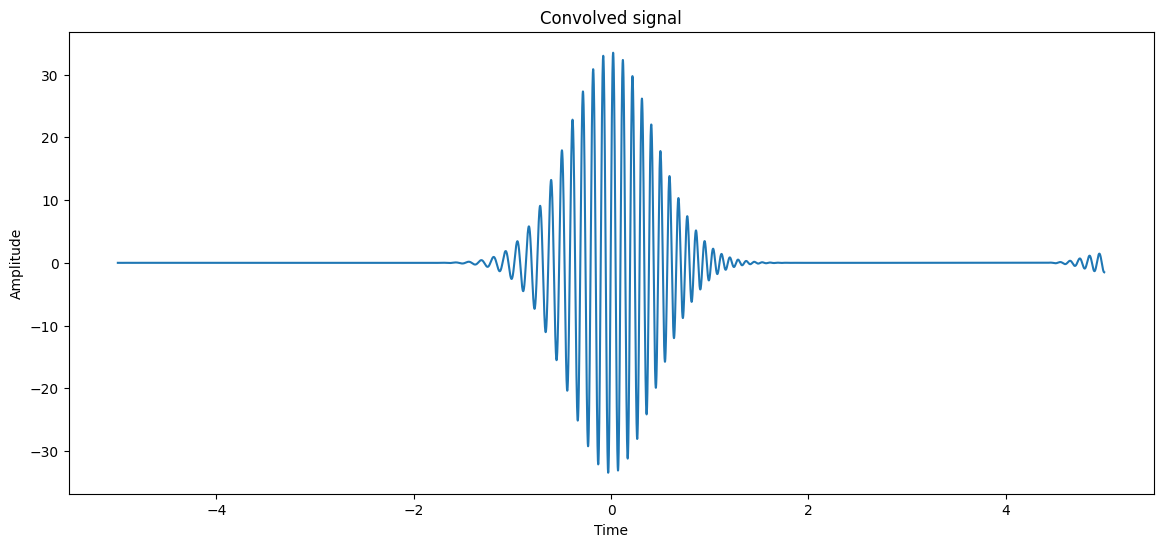

In [31]:
convolved_signal = np.convolve(chirp,np.real(morlet),mode="same")

plt.figure(figsize=(14, 6))
plt.plot(time_signal,convolved_signal)
plt.title('Convolved signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

There are some points where the convolution is zero, even in regions of high similarity between the wavelet and the signal. **Is this OK?** If it's not, propose a solution to that.

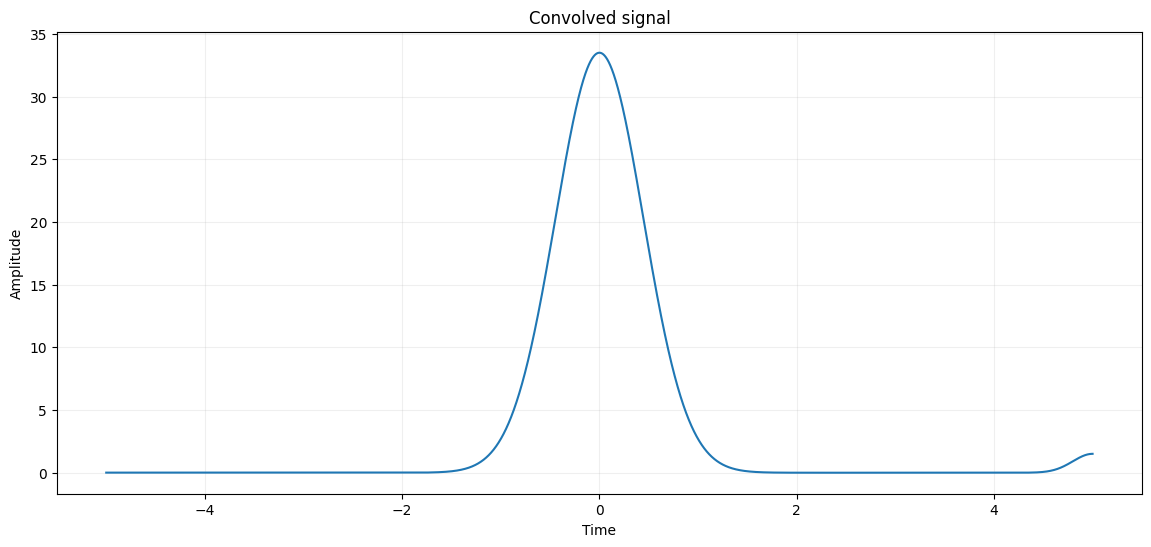

In [32]:
convolved_signal = np.abs(np.convolve(chirp,morlet,mode="same"))

plt.figure(figsize=(14, 6))
plt.plot(time_signal,convolved_signal)
plt.title('Convolved signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.grid(alpha=0.2)

# **Image Compression**
For this part, we'll use the Discrete Wavelet Transform (DWT) implemented as a filter bank to do image compression. The first step is to have an image to compress. For doing so you can use the following piece of code to download an image of Trudy.

In [33]:
!wget https://raw.githubusercontent.com/jhonygiraldo/jhonygiraldo.github.io/main/Trudy_for_compression.jpeg

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


**Visualize image:** With the following code you can visualize the image. If you're using Google Collab, most probably you already have the open cv library installed. If you're using Jupyter Notebook for example, you'll have to install open cv if it's not already installed.

In [34]:
# Let us define a function for visualizing images
def show_image(image, title='Input Image', font_size=12,fig_size = (10, 10)):
  #A function that uses matplotlib to show grayscale images
  plt.figure(figsize=fig_size)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=font_size)
  plt.axis('off')

(1531, 1532)


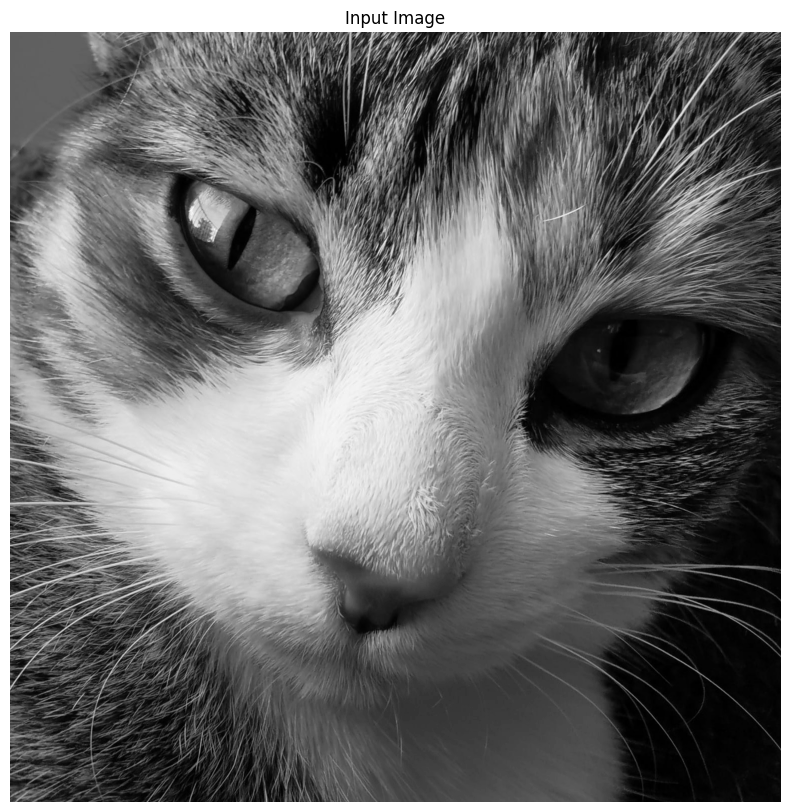

In [35]:
import cv2

# Load your image as a grayscale
input_image = cv2.imread('Trudy_for_compression.jpeg', cv2.IMREAD_GRAYSCALE)
print(input_image.shape)
# Display the original image
show_image(input_image, 'Input Image')

If you use some wavelet function (Biorthogonal 1.3 in this case), the 1-level 2D wavelet decomposition of our input image is given as follows:

In [36]:
# # You can see a list of wavelet families
import pywt
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [37]:
# For each family, you can list the available wavelets
pywt.wavelist(family='db', kind='all')

['db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38']

In the previous image we applied a threshold in the wavelet coefficients for visualization purposes. **Please explain the meaning of each of these 4 images**.

**YOUR ANSWER HERE:** The top left square is the original image that was downsampled by factor 2, the top right is the horizontal high pass on that image, the bottom left is the vertical high-pass and the bottom right is the diagonal high pass.

Now, you should compute the six-levels 2D wavelet decomposition of the input image with a Daubechies wavelet with six vanishing moments using the PyWavelet library. Please check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2

In [38]:
decomp = pywt.wavedec2(input_image,'db6',level=6)

* Set a threshold of value of 100 and take to zero the values less than that in the 2D wavelet decomposition. **Note:** You should only threshold the outputs of the high-pass filters.



In [42]:
for level in decomp[1:]:
    for decompo in level:
        #seuil = 100/255*decompo.max()
        for i in range(len(decompo)):
            for j in range(len(decompo[0])):
                if(decompo[i][j]<100):
                    decompo[i][j] = 0

* Compute the IDWT to reconstruct the image after the "compression". Check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2 as a reference.

-63
(1532, 1532)


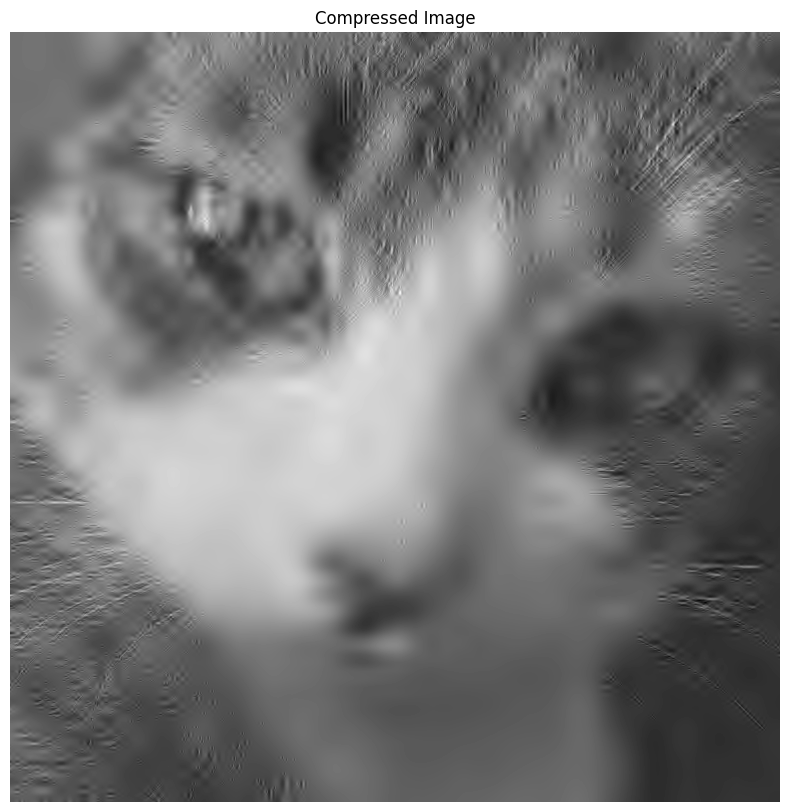

In [43]:
reco_6 = pywt.waverec2(decomp,'db6')

#plot compressed image
reco_6 = reco_6.astype(int)
print(reco_6.min())
reco_6 += -reco_6.min()
print(reco_6.shape)
show_image(reco_6, 'Compressed Image')

What's the compression ratio?

In [44]:
# Your code here
#reco_6 = reco_6.astype(int)
s = 0
m,n = reco_6.shape
for i in range(m):
    for j in range(n):
        if reco_6[i][j] < 0.001:
            s+=1
print(reco_6)
print("Compression ratio =",s/(m*n))

[[158 158 158 ... 134 134 135]
 [158 158 158 ... 133 133 133]
 [158 158 158 ... 132 132 132]
 ...
 [125 124 124 ...  70  69  69]
 [126 125 125 ...  69  69  69]
 [127 126 125 ...  69  69  69]]
Compression ratio = 4.260714845693951e-07


# **Putting everything together**

In this exercise we'll analyze the Peak Signal to Noise Ration (PSNR) of the compressed images for different thresholds. For doing so, we'll give you the function to compute the PSNR between the original and compressed image.

In [45]:
def psnr(original_image, compressed_image):
    h,w = original_image.shape
    mse = np.sum(np.abs(original_image-compressed_image[0:1531])**2)/(h*w)
    return 20* np.log10(255**2/mse)

Now, you have to create a function codec that receives the input image, the wavelet to be used, the number of levels, and the threshold value. This function returns the compressed image and the compression ratio. **Note:** You already did that previously.

In [46]:
def codec(input_image,wavelet='db4',num_levels=6,threshold=100):
  # Your code here
    decomp = pywt.wavedec2(input_image,wavelet,num_levels)
    decompo_6 = decomp[0]
    seuil = threshold/255*decompo_6.max()
    for i in range(len(decompo_6)):
        for j in range(len(decompo_6[0])):
              if(decompo_6[i][j]<seuil):
                  decompo_6[i][j] = 0   
    reco_6 = pywt.waverec2(decomp,wavelet)
    s = 0
    m,n = reco_6.shape
    for i in range(m):
        for j in range(n):
            if reco_6[i][j] < 0.001:
                s+=1
    return reco_6,s/(m*n)

Now, we compare the performance of the 'db4' and the 'bior1.3' wavelets in terms of compression ratio and PSNR for different thresholds.

In [48]:
wavelet_1 = 'db4'
wavelet_2 = 'bior1.3'
thresholds = [5,10,20,40,80,100]
num_levels=6

# Your code here
for t in thresholds:
    print("Threshold =",t)
    comp_db4, ratio_db4 = codec(input_image,wavelet_1,num_levels,t)
    comp_bior, ration_bior = codec(input_image,wavelet_2,num_levels,t)
    print("Compression ratio db4 =", ratio_db4,"Compression ratio bior1.3 =",ration_bior)
    print("PSNR db4 =", psnr(input_image,comp_db4),"PSNR bior1.3 =", psnr(input_image,comp_bior))

Threshold = 5
Compression ratio db4 = 0.0033425307964469048 Compression ratio bior1.3 = 0.0033425307964469048
PSNR db4 = 614.7240922734672 PSNR bior1.3 = 134.29949738042663
Threshold = 10
Compression ratio db4 = 0.02626560273776493 Compression ratio bior1.3 = 0.0033425307964469048
PSNR db4 = 91.11145568238491 PSNR bior1.3 = 134.29949738042663
Threshold = 20
Compression ratio db4 = 0.04313888566968212 Compression ratio bior1.3 = 0.023212800550825214
PSNR db4 = 78.93002239384639 PSNR bior1.3 = 79.85389969952942
Threshold = 40
Compression ratio db4 = 0.0774908991130896 Compression ratio bior1.3 = 0.08043718342888696
PSNR db4 = 62.26803706626938 PSNR bior1.3 = 55.598943514502174
Threshold = 80
Compression ratio db4 = 0.2028274955858994 Compression ratio bior1.3 = 0.19690936266523051
PSNR db4 = 36.716142273558745 PSNR bior1.3 = 34.96170354412511
Threshold = 100
Compression ratio db4 = 0.3044677003728978 Compression ratio bior1.3 = 0.28016500896454405
PSNR db4 = 28.914779281426732 PSNR bior1

**QUESTIONS**

1) Which wavelet is better for the Trudy_for_compression.jpeg image and why?\
For all thresholds, the db4 wavelet produces a result that has a higher compression ratio than the bior1.3 wavelet whilst having a greater PSNR. The db4 wavelet is thus better at compressing Trudy_for_compression.jpeg.

# Supplementary Exercises (Optional)
1. Designing and using custom filters with the pyWavelets library
Reference (https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)
2. Propose and explore custom wavelets that achieve equivalent or higher compression ratio on the Trudy image explored previously. **P.S** You are free to explore any approach here.